# Explaining market value of players using SHAP

I am going to explain market predictions for two players Messi and Courtois. I still use fifa-23 dataset, but this time I base my prediction on one more variable - 'Club Position' to get better results. Models that I use are Random Forest Regressor and Catboost Regressor.

In [15]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np


def read_dataset():
    return pd.read_csv("archive/fifa.csv")

def plot_feature_performance(X, y, y_pred, i):
    plt.scatter(X.iloc[:, i], y, color="green")
    plt.plot(X.iloc[:, i], y_pred, color="blue", linewidth=3)
    plt.xticks(())
    plt.yticks(())
    plt.show()


def plot_bars(height, labels, num):
    arr = np.vstack([labels, height])
    ind = np.lexsort(arr)[::-1][:num]
    plt.bar(np.arange(num), arr[1, ind])
    plt.xticks(np.arange(num), arr[0, ind], rotation=-60, fontsize=10)
    plt.show()

In [16]:
from sklearn.model_selection import train_test_split
import shap
import dalex as dx

df = read_dataset()
y = df["Value(in Euro)"]

idx_1, idx_2 = 0, 6
name_1, name_2 = df["Known As"].iloc[idx_1],  df["Known As"].iloc[idx_2]

df = df[['Attacking Work Rate',
       'Defensive Work Rate', 'Pace Total', 'Shooting Total', 'Passing Total',
       'Dribbling Total', 'Defending Total', 'Physicality Total', 'Crossing',
       'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys',
       'Dribbling', 'Curve', 'Freekick Accuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance',
       'Shot Power', 'Jumping', 'Stamina', 'Strength', 'Long Shots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'Standing Tackle', 'Sliding Tackle',
       'Goalkeeper Diving', 'Goalkeeper Handling', ' GoalkeeperKicking',
       'Goalkeeper Positioning', 'Goalkeeper Reflexes', 'Club Position']]

scale_mapper = {"Low":1, "Medium":2, "High":3}
df["Attacking Work Rate"].replace(scale_mapper, inplace=True)
df["Defensive Work Rate"].replace(scale_mapper, inplace=True)

one_hot = pd.get_dummies(df['Club Position'])
df = df.drop('Club Position',axis = 1)
df = df.join(one_hot)

X100 = df.iloc[:100].copy()
X_train, X_test, y_train, y_test = train_test_split(df, y)

print("Names of players to explain predictions of their value: {}, {}".format(name_1, name_2))

Names of players to explain predictions of their value: L. Messi, T. Courtois


First model that I use is RandomForestRegressor. I have already used and shortly described in homework 1.

Coefficient of determination: 0.78
Scatter plot: predictions vs truth


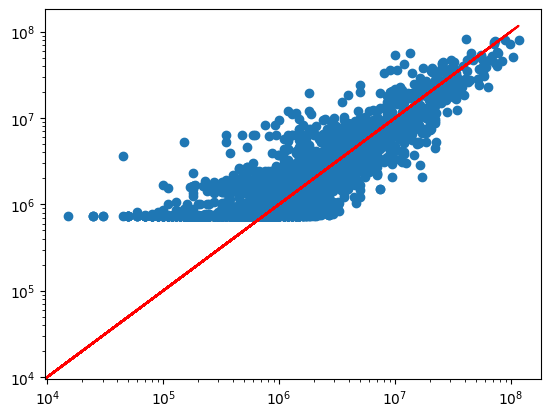

SHAP Decomposition for observation L. Messi


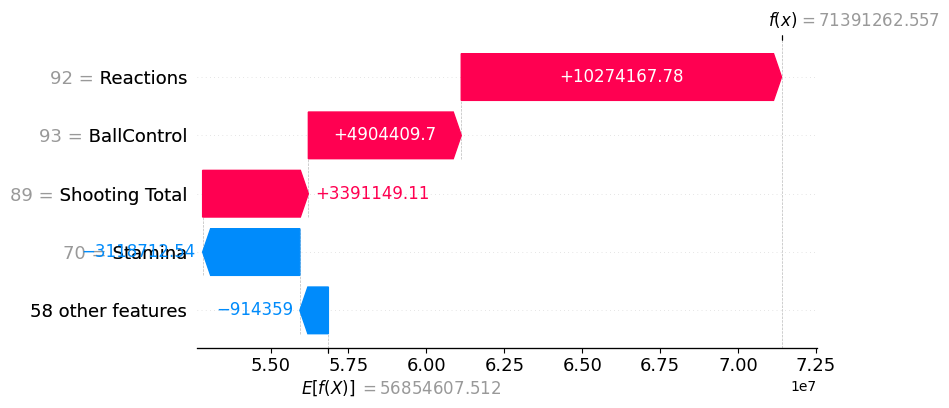

SHAP Decomposition for observation T. Courtois


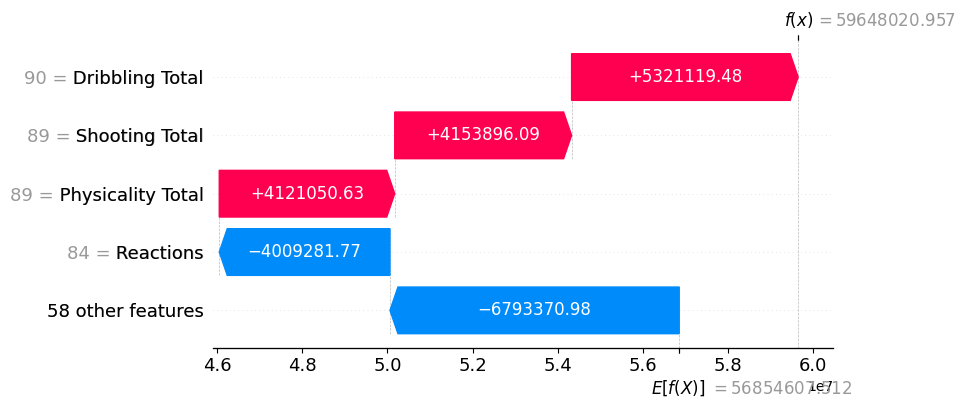

Preparation of a new explainer is initiated

  -> data              : 100 rows 62 cols
  -> target variable   : Not specified!
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7f3efab69ca0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.59e+07, mean = 5.69e+07, max = 1.55e+08
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> model_info        : package sklearn

A new explainer has been created!
DALEX Decomposition for observation L. Messi


/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



DALEX Decomposition for observation T. Courtois


In [17]:
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print("Coefficient of determination: {:.2f}".format(r2_score(y_test, y_pred)))

print("Scatter plot: predictions vs truth")
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, color='r')
plt.yscale('log')
plt.xscale('log')
plt.show()

explainer = shap.Explainer(regr.predict, X100)
shap_values = explainer(X100)

print('SHAP Decomposition for observation ' + name_1)
shap.plots.waterfall(shap_values[idx_1], max_display=5)

print('SHAP Decomposition for observation ' + name_2)
shap.plots.waterfall(shap_values[idx_2], max_display=5)

explainer = dx.Explainer(regr, X100)
print('DALEX Decomposition for observation ' + name_1)
explainer.predict_parts(X100.iloc[[idx_1]], type="shap").plot(max_vars=5)

print('DALEX Decomposition for observation ' + name_2)
explainer.predict_parts(X100.iloc[[idx_2]], type="shap").plot(max_vars=5)

Second model is Catboost Regressor. The main idea of boosting is to sequentially combine many weak models and thus through greedy search create a strong competitive predictive model.

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Coefficient of determination: 0.83


/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Scatter plot: predictions vs truth


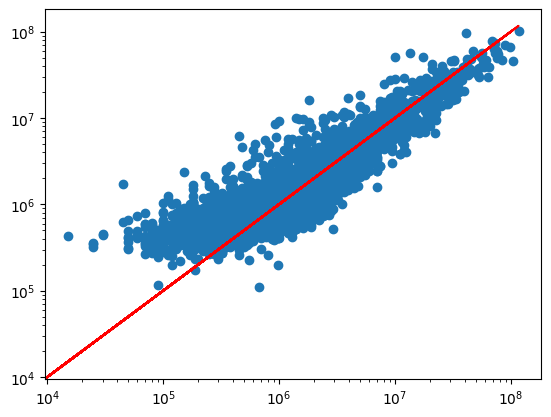

SHAP Decomposition for observation L. Messi


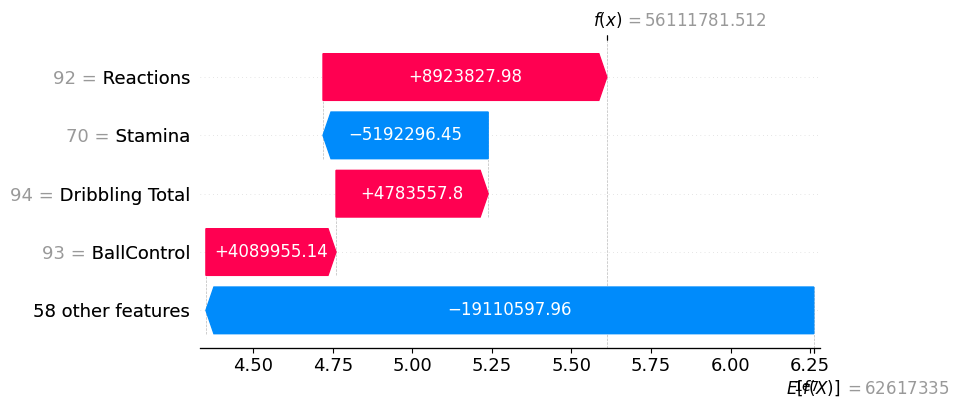

SHAP Decomposition for observation T. Courtois


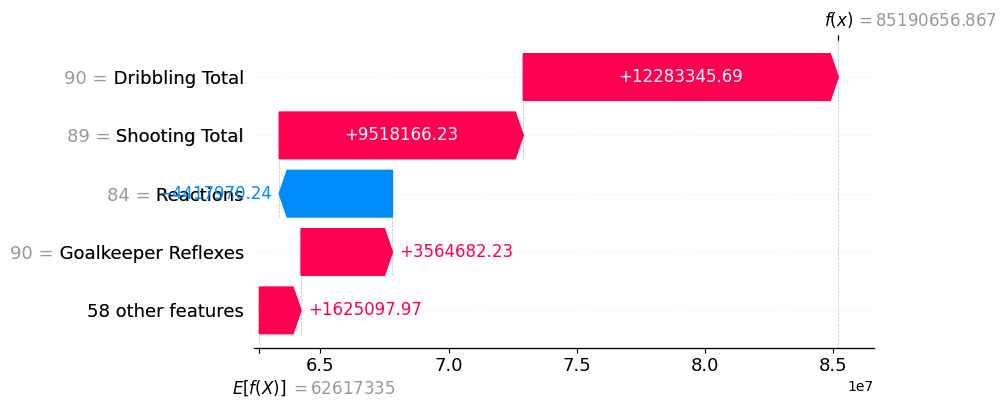

Preparation of a new explainer is initiated

  -> data              : 100 rows 62 cols
  -> target variable   : Not specified!
  -> model_class       : catboost.core.CatBoostRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7f3efab69ca0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 9.44e+06, mean = 6.26e+07, max = 1.87e+08
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> model_info        : package catboost

A new explainer has been created!
DALEX Decomposition for observation L. Messi


/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/catboost/core.py:141

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



DALEX Decomposition for observation T. Courtois


/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/catboost/core.py:141

In [18]:
from catboost import CatBoostRegressor

regr = CatBoostRegressor(iterations=200, early_stopping_rounds=10, learning_rate=0.1, depth=5, verbose=False)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print("Coefficient of determination: {:.2f}".format(r2_score(y_test, y_pred)))
explainer = shap.Explainer(regr.predict, X100)
shap_values = explainer(X100)

print("Scatter plot: predictions vs truth")
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, color='r')
plt.yscale('log')
plt.xscale('log')
plt.show()

print('SHAP Decomposition for observation ' + name_1)
shap.plots.waterfall(shap_values[idx_1], max_display=5)

print('SHAP Decomposition for observation ' + name_2)
shap.plots.waterfall(shap_values[idx_2], max_display=5)

explainer = dx.Explainer(regr, X100)
print('DALEX Decomposition for observation ' + name_1)
explainer.predict_parts(X100.iloc[[idx_1]], type="shap").plot(max_vars=5)

print('DALEX Decomposition for observation ' + name_2)
explainer.predict_parts(X100.iloc[[idx_2]], type="shap").plot(max_vars=5)

MLP - multi-layer perceptron is a neural network that consists of at least 3 layers. One layer usually consist of a linear and an activation.

Coefficient of determination: 0.32
Scatter plot: predictions vs truth


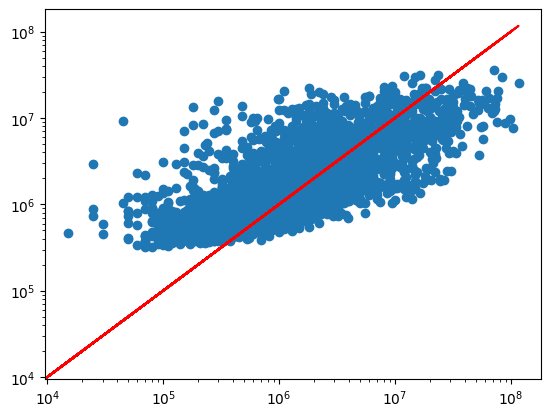

SHAP Decomposition for observation L. Messi


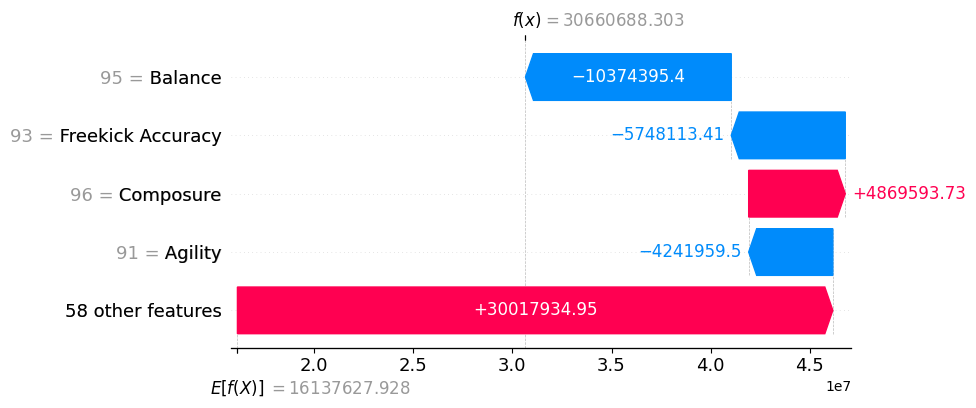

SHAP Decomposition for observation T. Courtois


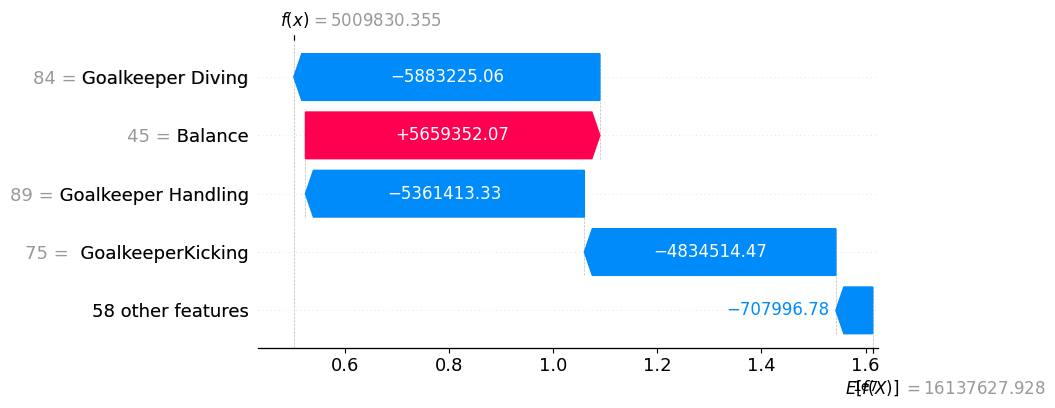

Preparation of a new explainer is initiated

  -> data              : 100 rows 62 cols
  -> target variable   : Not specified!
  -> model_class       : sklearn.neural_network._multilayer_perceptron.MLPRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7f3efab69ca0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.46e+06, mean = 1.61e+07, max = 3.86e+07
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> model_info        : package sklearn

A new explainer has been created!
DALEX Decomposition for observation L. Messi


/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPRegressor was fitted without feature names

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPRegressor was fitted without feature names

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPRegressor was fitted without feature names

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPRegressor was fitted without feature names

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPRegressor was fitted without 

DALEX Decomposition for observation T. Courtois


/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPRegressor was fitted without feature names

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPRegressor was fitted without feature names

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPRegressor was fitted without feature names

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPRegressor was fitted without feature names

/home/jskrajny/PycharmProjects/eXplainableMachineLearning-2023/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPRegressor was fitted without 

In [19]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=1000, early_stopping=True,
                    hidden_layer_sizes=(64, 128, 128, 64), learning_rate_init=0.001,
                    learning_rate='invscaling')
regr.fit(X_train.values, y_train)
y_pred = regr.predict(X_test.values)

print("Coefficient of determination: {:.2f}".format(r2_score(y_test, y_pred)))
explainer = shap.Explainer(regr.predict, X100.values)
shap_values = explainer(X100)


print("Scatter plot: predictions vs truth")
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, color='r')
plt.yscale('log')
plt.xscale('log')
plt.show()

print('SHAP Decomposition for observation ' + name_1)
shap.plots.waterfall(shap_values[idx_1], max_display=5)

print('SHAP Decomposition for observation ' + name_2)
shap.plots.waterfall(shap_values[idx_2], max_display=5)

explainer = dx.Explainer(regr, X100)
print('DALEX Decomposition for observation ' + name_1)
explainer.predict_parts(X100.iloc[[idx_1]], type="shap").plot(max_vars=5)

print('DALEX Decomposition for observation ' + name_2)
explainer.predict_parts(X100.iloc[[idx_2]], type="shap").plot(max_vars=5)

### 4.
As we can see these two observations have different variables of the highest importance for RandomForestRegressor.
Messi - 'Reactions', Courtois - 'Dribbling Total'.
### 5.
Variable 'Reactions' has positive influence on Messi's market value and negative for Courtois's market value.
### 6.
They differ mostly by small relatively number, but there are some cases when some variables are in top 4 for one package and are not in another.
### 7.
As we can see there are differences on variables importance on same observation between two presented models.
For example:
- Catboost claims that Goalkeeper Handling is important for Courtois's value (which is definitely true), but Random Forest do not.
- MLP claims that Goalkeeper Diving is the most important variable for Courtois but other models do not
    (Goalkeeper certainly should have good diving skills. The fact that only MLP (model that performs the worst) sees is interesting.)